In [1]:
import csv
import cv2
import numpy as np
from scipy.misc import imread

def load_path(filename, angle_offset=0.2):
    '''
    Reading the csv file and loading the image paths (center, left, right) and angles
    '''
    imgs = []
    angles = []
    with open(filename) as csvfile:
        has_header = csv.Sniffer().has_header(csvfile.read(1024))
        csvfile.seek(0)
        reader = csv.reader(csvfile)
        if has_header: next(reader)
        for center_name, left_name, right_name, angle, throttle, brake, speed in reader:
            
            if float(speed) >= 20:
                center_name = 'data/'+center_name
                center_img = imread(center_name, mode='RGB')
                imgs.append(center_img)
                angles.append(float(angle))
                imgs.append(np.fliplr(center_img))
                angles.append(-float(angle))

                left_name = 'data/' + left_name.strip()
                imgs.append(imread(left_name, mode='RGB'))
                angles.append(float(angle) + 0.2)

                right_name = 'data/' + right_name.strip()
                imgs.append(imread(right_name, mode='RGB'))
                angles.append(float(angle) - 0.2)
    print(len(imgs), len(angles))
    return np.array(imgs), np.array(angles)

In [2]:
X_train, y_train = load_path('data/driving_log.csv')

29328 29328


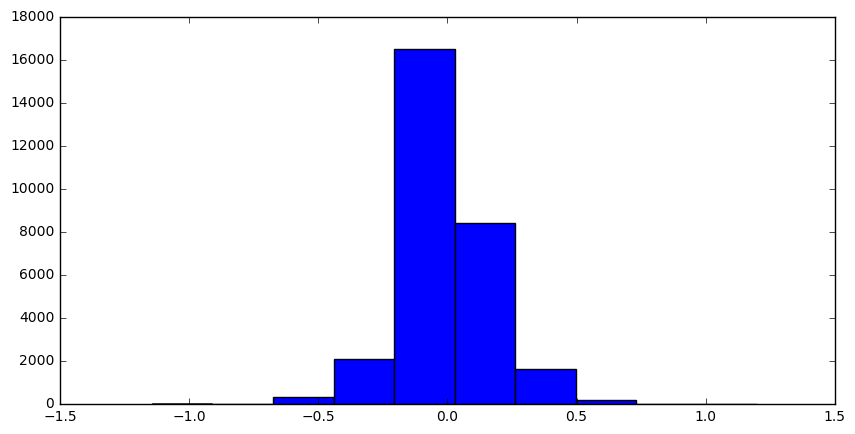

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.hist(y_train)
plt.show()

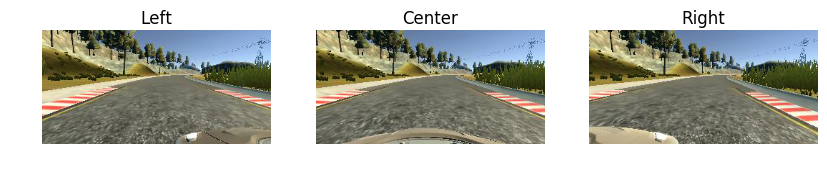

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Left')
plt.imshow(X_train[998])
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Center')
plt.imshow(X_train[1000])
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Right')
plt.imshow(X_train[1003])

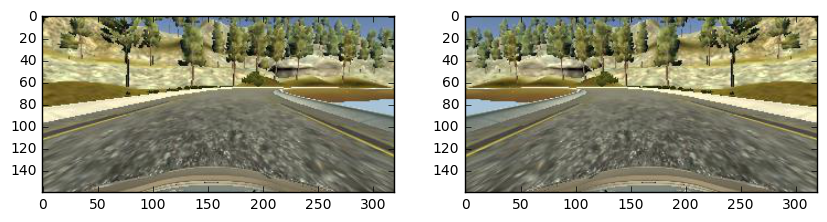

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(X_train[4000])
plt.subplot(1,2,2)
plt.imshow(X_train[4001])

In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, MaxPooling2D, Activation, Dropout, Lambda, Convolution2D, Cropping2D, ELU, BatchNormalization

Using TensorFlow backend.


In [15]:
def comma():
    input_shape = (160, 320, 3)
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape, output_shape=input_shape))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    model.add(Convolution2D(16,8,8,subsample=(4,4), border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(32,5,5,subsample=(2,2),border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(64,5,5,subsample=(2,2),border_mode='same'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Dense(1))
    return model

In [7]:
def nvidia():
    input_shape = (160, 320, 3)
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5,input_shape=input_shape,output_shape=input_shape))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    model.add(Convolution2D(24,5,5,subsample=(2,2)))
    model.add(BatchNormalization())
    model.add(Convolution2D(36,5,5,subsample=(2,2)))
    model.add(BatchNormalization())
    model.add(Convolution2D(48,5,5,subsample=(2,2)))
    model.add(BatchNormalization())
    model.add(Convolution2D(64,3,3))
    model.add(BatchNormalization())
    model.add(Convolution2D(64,3,3))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [18]:
model = comma()
model.summary()
# model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
# model.save('comma_5.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 80, 16)        3088      
_________________________________________________________________
elu_1 (ELU)                  (None, 17, 80, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 40, 32)         12832     
_________________________________________________________________
elu_2 (ELU)                  (None, 9, 40, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 20, 64)         51264     
__________

C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), padding="same", strides=(4, 4))`
C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same", strides=(2, 2))`
C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", strides=(2, 2))`


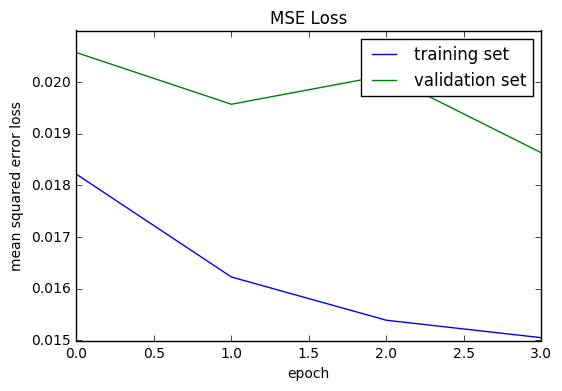

In [9]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('MSE Loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [14]:
model = nvidia()
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
model.save('nvidia_5.h5')

C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2))`
C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2))`
C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2))`
C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\Bhavesh\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


Train on 25715 samples, validate on 6429 samples
Epoch 1/10
25715/25715 [==============================] - 54s - loss: 0.3643 - val_loss: 0.0230
Epoch 2/10
25715/25715 [==============================] - 51s - loss: 0.0225 - val_loss: 0.0204
Epoch 3/10
25715/25715 [==============================] - 50s - loss: 0.0213 - val_loss: 0.0192
Epoch 4/10
25715/25715 [==============================] - 50s - loss: 0.0215 - val_loss: 0.0230
Epoch 5/10
25715/25715 [==============================] - 50s - loss: 0.0219 - val_loss: 0.0203
Epoch 6/10
25715/25715 [==============================] - 50s - loss: 0.0227 - val_loss: 0.0206
Epoch 7/10
25715/25715 [==============================] - 50s - loss: 0.0235 - val_loss: 0.0222
Epoch 8/10
25715/25715 [==============================] - 50s - loss: 0.0233 - val_loss: 0.0215
Epoch 9/10
25715/25715 [==============================] - 51s - loss: 0.0229 - val_loss: 0.0190
Epoch 10/10
25715/25715 [==============================] - 51s - loss: 0.0220 - val_los

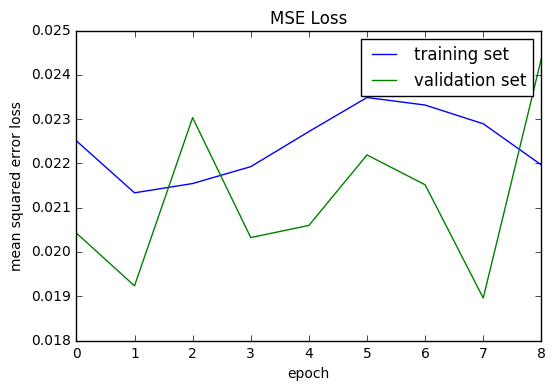

In [15]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('MSE Loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()